LAB 5 - PARTE 1

Librerías a utilizar

In [41]:
from scapy.all import * # Packet manipulation
import pandas as pd # Pandas - Create and Manipulate DataFrames
import numpy as np # Math Stuff (don't worry only used for one line :] )
import binascii # Binary to Ascii 
import seaborn as sns
sns.set(color_codes=True)
%matplotlib inline

Capturar 10 paquetes y mostrar el tipo de dato, la longitud y el contenido del pcap

In [42]:
num_of_packets_to_sniff = 10
pcap = sniff(count=num_of_packets_to_sniff)

# rdpcap returns packet list
## packetlist object can be enumerated 
print(type(pcap))
print(len(pcap))
print(pcap)
pcap[0]

<class 'scapy.plist.PacketList'>
10
<Sniffed: TCP:10 UDP:0 ICMP:0 Other:0>


<Ether  dst=a0:e7:0b:1b:b8:90 src=fc:52:8d:63:4c:7a type=IPv4 |<IP  version=4 ihl=5 tos=0x0 len=1500 id=12452 flags=DF frag=0 ttl=103 proto=tcp chksum=0x119e src=104.46.162.226 dst=192.168.0.33 |<TCP  sport=https dport=51021 seq=867856813 ack=1081311471 dataofs=5 reserved=0 flags=A window=2051 chksum=0x39a9 urgptr=0 |<Raw  load='\x16\x03\x03\x11\\x95\x02\x00\x00Q\x03\x03d;L\\xa0\\x82\x0b\\xcb\\xd7m:\\xefՔ2\\xcf&\x19\\xc8\\xcd<\\xba<\x0ba\\xfbg\\xe4tr\\x95\x0c\\x84 \x04\x1f\x00\x00\\x96\x00\\xd41\\x9ff\\x8e\\xf6\\xc4/\\xdb\\xc2\\xe7\\xf5Õ4W\\xf9%\\xb3\\x93&\\xf9+}\x15q\\xc00\x00\x00\t\x00\x17\x00\x00\\xff\x01\x00\x01\x00\x0b\x00\x0f\\xcb\x00\x0f\\xc8\x00\t\\xcb0\\x82\t\\xc70\\x82\x07\\xaf\\xa0\x03\x02\x01\x02\x02\x133\x00\\x99+\\xc4\\xee\\xcez\\xc3u\\xb2\\xc5V\x00\x00\x00\\x99+\\xc40\r\x06\t*\\x86H\\x86\\xf7\r\x01\x01\x0c\x05\x000Y1\x0b0\t\x06\x03U\x04\x06\x13\x02US1\x1e0\x1c\x06\x03U\x04\n\x13\x15Microsoft Corporation1*0(\x06\x03U\x04\x03\x13!Microsoft Azure TLS Issuing CA 010\x1e\x17\

Convertir a DF

In [43]:
# Obtenemos los campos de IP/TCP/UDP que seran las columnas de nuestro DF
ip_fields = [field.name for field in IP().fields_desc]
tcp_fields = [field.name for field in TCP().fields_desc]
udp_fields = [field.name for field in UDP().fields_desc]

#Concatenamos todos los campos
dataframe_fields = ip_fields + ['time'] + tcp_fields + ['payload','payload_raw','payload_hex']

# Creamos un DF en blanco con los campos como columnas
df = pd.DataFrame(columns=dataframe_fields)
for packet in pcap[IP]:
    # Obtenemos los valores de los campos de cada fila
    field_values = []
    # A;adimos todos los valores de los campos de IP al df
    for field in ip_fields:
        if field == 'options':
            # Obtenemos el numero de opciones del IP Header
            field_values.append(len(packet[IP].fields[field]))
        else:
            field_values.append(packet[IP].fields[field])
    
    field_values.append(packet.time)
    
    layer_type = type(packet[IP].payload)
    for field in tcp_fields:
        try:
            if field == 'options':
                field_values.append(len(packet[layer_type].fields[field]))
            else:
                field_values.append(packet[layer_type].fields[field])
        except:
            field_values.append(None)
    
    # Agregamos el payload
    field_values.append(len(packet[layer_type].payload))
    field_values.append(packet[layer_type].payload.original)
    field_values.append(binascii.hexlify(packet[layer_type].payload.original))
    # Agregamos la fila al df
    df_append = pd.DataFrame([field_values], columns=dataframe_fields)
    df = pd.concat([df, df_append], axis=0)

# Reset Index
df = df.reset_index()
# Drop old index column
df = df.drop(columns="index")

print(df.head(5))

  version ihl tos   len     id flags frag  ttl proto chksum  ... dataofs  \
0       4   5   0  1500  12452    DF    0  103     6   4510  ...       5   
1       4   5   0  1500  12453    DF    0  103     6   4509  ...       5   
2       4   5   0  1500  12454    DF    0  103     6   4508  ...       5   
3       4   5   0   166  12455    DF    0  103     6   5841  ...       5   
4       4   5   0    40  57793    DF    0  128     6      0  ...       5   

  reserved flags  window chksum urgptr options payload  \
0        0     A    2051  14761      0       0    1460   
1        0     A    2051  36329      0       0    1460   
2        0     A    2051  58974      0       0    1460   
3        0    PA    2051  44490      0       0     126   
4        0     A     517  52212      0    None       0   

                                         payload_raw  \
0  b'\x16\x03\x03\x11\x95\x02\x00\x00Q\x03\x03d;L...   
1  b'ata.microsoft.com\x82\x19*.pipe.aria.microso...   
2  b'\x9cU\x9bQG,3@\xf4\x8

Mostrar columnas 'Src Addres', 'Dst Address', 'Src Port' y 'Dst Port'

In [44]:
df[['src','dst','sport','dport']]

,src,dst,sport,dport
0,104.46.162.226,192.168.0.33,443,51021
1,104.46.162.226,192.168.0.33,443,51021
2,104.46.162.226,192.168.0.33,443,51021
3,104.46.162.226,192.168.0.33,443,51021
4,192.168.0.33,104.46.162.226,51021,443
5,104.46.162.226,192.168.0.33,443,51020
6,104.46.162.226,192.168.0.33,443,51020
7,192.168.0.33,104.46.162.226,51020,443
8,192.168.0.33,104.46.162.226,51021,443
9,104.46.162.226,192.168.0.33,443,51020


Estadísticas

    IP origen más frecuente

In [45]:
frequent_address1 = df['src'].describe()['top']
print(frequent_address1)

104.46.162.226


    IP destino más frecuente

In [46]:
frequent_address2 = df['dst'].describe()['top']
print(frequent_address2)

192.168.0.33


    ¿A qué IPs se comunica la IP del inciso a?

In [47]:
print(df[df['src'] == frequent_address1]['dst'].unique(),"\n\n")

['192.168.0.33'] 




    ¿A qué puertos destino se comunica la IP del inciso a?

In [48]:
print(df[df['src'] == frequent_address1]['dport'].unique(),"\n\n")

[51021 51020] 




    ¿A qué puertos origen se comunica la IP del inciso b?

In [49]:
print(df[df['dst'] == frequent_address2]['sport'].unique(),"\n\n")

[443] 




    El propósito de los puertos que más aparecen en los incisos d y e es porque el 443 es un puerto de red, establece conexión segura entre cliente y servidor y es porque al momento de capturar los paquetes, mi computadora estaba conectada a internet con varias pestañas de navegación. Ahora, respecto a los puertos 51020 y 51021 es porque son puertos que corresponden a aplicaciones específicas de mi sistema y que en ese momento las tenía en ejecución.

Gráficas

    IPs origen vs la suma de los payloads enviados de dichas direcciones

In [50]:
# Primero hacemos otro dataframe que incluya el payload
df[['src','dst','sport','dport', 'payload']]

,src,dst,sport,dport,payload
0,104.46.162.226,192.168.0.33,443,51021,1460
1,104.46.162.226,192.168.0.33,443,51021,1460
2,104.46.162.226,192.168.0.33,443,51021,1460
3,104.46.162.226,192.168.0.33,443,51021,126
4,192.168.0.33,104.46.162.226,51021,443,0
5,104.46.162.226,192.168.0.33,443,51020,1460
6,104.46.162.226,192.168.0.33,443,51020,1460
7,192.168.0.33,104.46.162.226,51020,443,0
8,192.168.0.33,104.46.162.226,51021,443,158
9,104.46.162.226,192.168.0.33,443,51020,1460


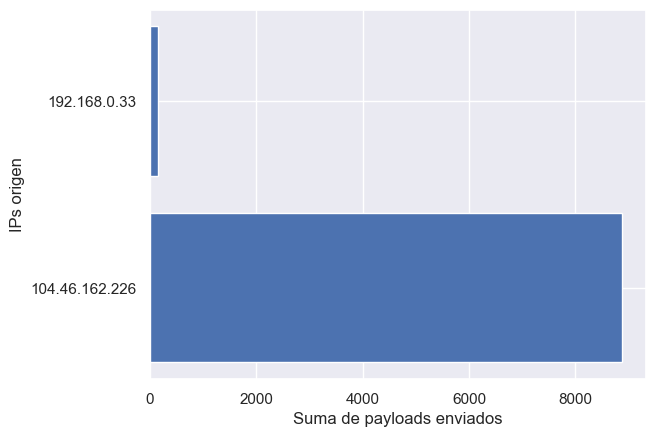

In [51]:
# Ahora ya podemos graficar
import pandas as pd
import matplotlib.pyplot as plt

# Agrupar los paquetes por dirección IP de origen y sumar los payloads de cada grupo.
payloads_por_ip = df.groupby('src')['payload'].sum()

# Crear la gráfica de barras horizontales.
plt.barh(payloads_por_ip.index, payloads_por_ip.values)

# Añadir etiquetas al eje Y y al eje X.
plt.ylabel('IPs origen')
plt.xlabel('Suma de payloads enviados')

# Mostrar la gráfica.
plt.show()

    IPs destino vs la suma de los payloads recibidos en dichas direcciones

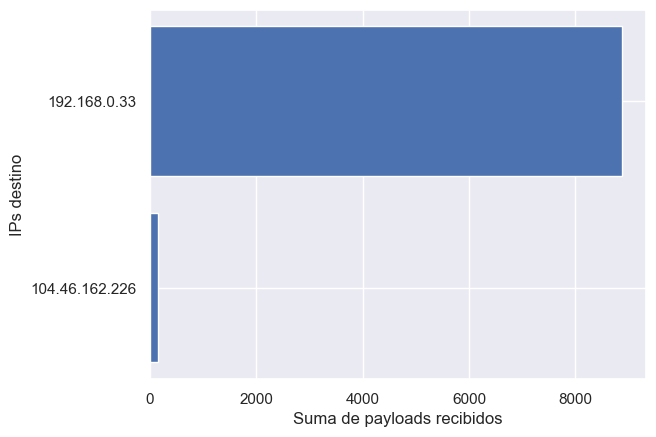

In [52]:
payloads_por_ip2 = df.groupby('dst')['payload'].sum()

plt.barh(payloads_por_ip2.index, payloads_por_ip2.values)
plt.ylabel('IPs destino')
plt.xlabel('Suma de payloads recibidos')
plt.show()

    Puertos origen vs la suma de los payloads enviados de dichos puertos

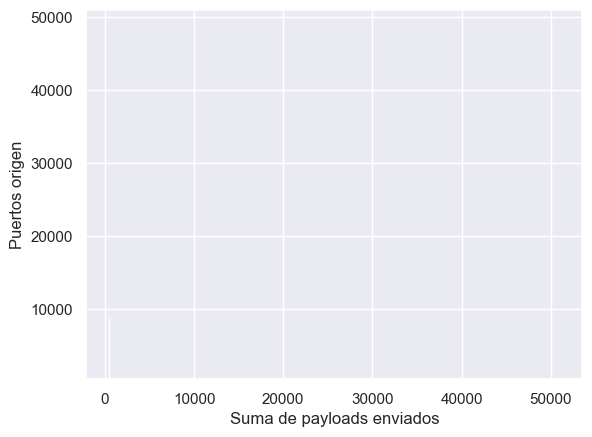

In [53]:
spuertos_unicos = df['sport'].unique()
payloads_por_puerto = df.groupby('sport')['payload'].sum()

plt.bar(payloads_por_puerto.index, payloads_por_puerto.values)
plt.ylim(min(spuertos_unicos), max(spuertos_unicos))
plt.ylabel('Puertos origen')
plt.xlabel('Suma de payloads enviados')
plt.show()

    Puertos destino vs la suma de los payloads recibidos en dichos puertos

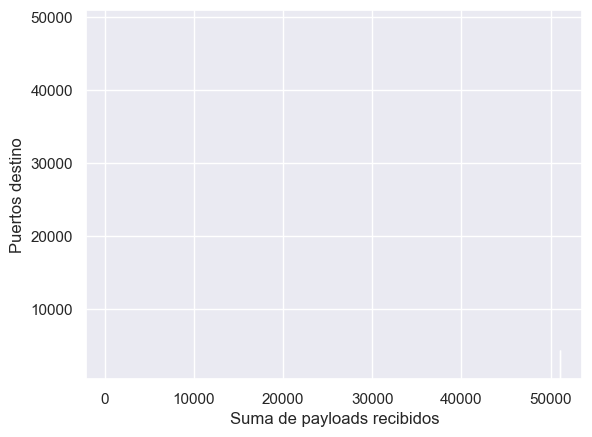

In [54]:
dpuertos_unicos = df['dport'].unique()
payloads_por_puerto2 = df.groupby('dport')['payload'].sum()

plt.bar(payloads_por_puerto2.index, payloads_por_puerto2.values)
plt.ylim(min(dpuertos_unicos), max(dpuertos_unicos))
plt.ylabel('Puertos destino')
plt.xlabel('Suma de payloads recibidos')
plt.show()

Investigación del payload

    Crear un nuevo DF que incluya únicamente las conexiones con la dirección IP origen más frecuente

    Obtenga un nuevo DF con las columnas Src Address, Dst Address y agrúpelas por payload

In [55]:
nuevo_df = df[df['src'] == frequent_address1]
nuevo_df2 = nuevo_df[['src', 'dst', 'payload']]

# Agrupar el dataframe por la columna 'load' y las columnas 'src' y 'dst' usando el método 'groupby()'.
nuevo_df3 = nuevo_df2.groupby(['payload', 'src', 'dst']).size().reset_index(name='count')
nuevo_df3

,payload,src,dst,count
0,126,104.46.162.226,192.168.0.33,1
1,1460,104.46.162.226,192.168.0.33,6


    Obtener la IP que más ha intercambiado bytes con la IP más frecuente. Esta IP es sospechosa por la cantidad de bytes intercambiados, entre todas las direcciones.

In [56]:
df2 = nuevo_df3.groupby('dst', as_index=False)['payload'].sum()
df3 = df2.sort_values('payload', ascending=False)
ip_intercambio_maximo = df3.iloc[0]['dst']
ip_intercambio_maximo

'192.168.0.33'

    Crear un nuevo DF con la conversación entre la IP más frecuente y la IP sospechosa

In [57]:
condicion = (df['src'] == frequent_address1) & (df['dst'] == ip_intercambio_maximo)
nuevo_df4 = df.loc[condicion]

payloads1 = df['payload_raw'].to_numpy()
print(payloads1, "\n\n")

payloads2 = df['payload_hex'].to_numpy()
print(payloads2, "\n\n")

[b'\x16\x03\x03\x11\x95\x02\x00\x00Q\x03\x03d;L\xa0\x82\x0b\xcb\xd7m:\xef\xd5\x942\xcf&\x19\xc8\xcd<\xba<\x0ba\xfbg\xe4tr\x95\x0c\x84 \x04\x1f\x00\x00\x96\x00\xd41\x9ff\x8e\xf6\xc4/\xdb\xc2\xe7\xf5\xc3\x954W\xf9%\xb3\x93&\xf9+}\x15q\xc00\x00\x00\t\x00\x17\x00\x00\xff\x01\x00\x01\x00\x0b\x00\x0f\xcb\x00\x0f\xc8\x00\t\xcb0\x82\t\xc70\x82\x07\xaf\xa0\x03\x02\x01\x02\x02\x133\x00\x99+\xc4\xee\xcez\xc3u\xb2\xc5V\x00\x00\x00\x99+\xc40\r\x06\t*\x86H\x86\xf7\r\x01\x01\x0c\x05\x000Y1\x0b0\t\x06\x03U\x04\x06\x13\x02US1\x1e0\x1c\x06\x03U\x04\n\x13\x15Microsoft Corporation1*0(\x06\x03U\x04\x03\x13!Microsoft Azure TLS Issuing CA 010\x1e\x17\r230308062016Z\x17\r240302062016Z0r1\x0b0\t\x06\x03U\x04\x06\x13\x02US1\x0b0\t\x06\x03U\x04\x08\x13\x02WA1\x100\x0e\x06\x03U\x04\x07\x13\x07Redmond1\x1e0\x1c\x06\x03U\x04\n\x13\x15Microsoft Corporation1$0"\x06\x03U\x04\x03\x0c\x1b*.events.data.microsoft.com0\x82\x01"0\r\x06\t*\x86H\x86\xf7\r\x01\x01\x01\x05\x00\x03\x82\x01\x0f\x000\x82\x01\n\x02\x82\x01\x01\x00\

    Examine los primeros bytes del contenido, ¿encuentra algún dato que no haga sentido que se envié a través del puerto explicado en el inciso f? La verdad no pero tengo la inquietud de que sí hay algún dato sospechoso.